Dataset Overview:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0      0.0             0.0  
1  M2044282225             0.0             0.0      0.0             0.0  
2   C553264065             0.0             0.0      1.0             0.0  
3    C38997010         21182.0             0.0      1.0             0.0  
4  M1230701703             0.0             0.0      0.0             0.0  

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219765 entries,

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


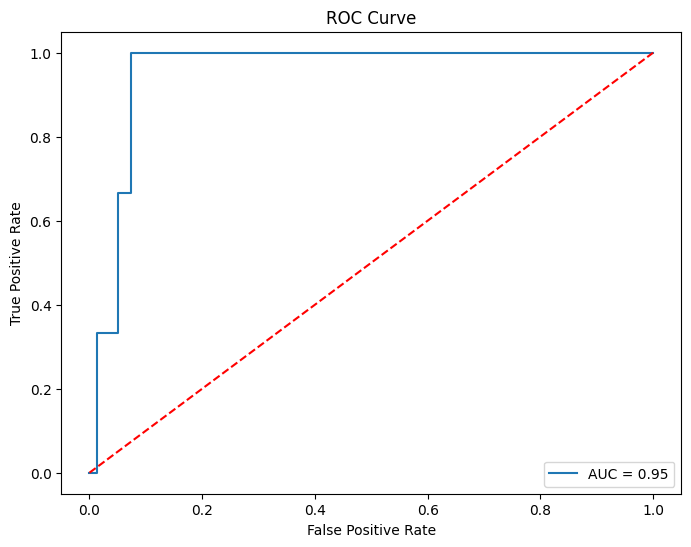

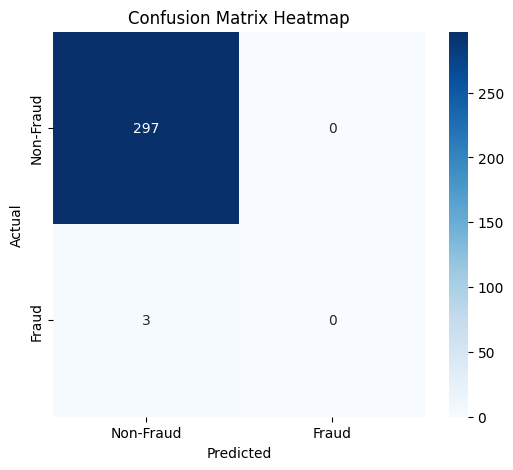

In [5]:
# Step 1: Import Necessary Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Load the Dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MyDataSet.csv')

# Step 3: Explore the Dataset
print("Dataset Overview:")
print(df.head())
print("\nDataset Information:")
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())
print("\nClass Distribution:\n", df['isFraud'].value_counts())

# Step 4: Data Preprocessing
# 4a. Handle Missing Values
df = df.dropna()

# 4b. Identify and Encode Categorical Variables
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if df[col].nunique() > 50:  # High cardinality
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
    else:
        df = pd.get_dummies(df, columns=[col], drop_first=True)

# 4c. Separate Features and Target
X = df.drop('isFraud', axis=1)
y = df['isFraud']

# 4d. Address Class Imbalance Using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Step 5: Feature Scaling
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

# Step 6: Reducing Dataset Size
X_resampled = X_resampled[:1000]
y_resampled = y_resampled[:1000]

df['Transaction_ID'] = df.index

# Saving the updated dataset with Transaction_ID
df.to_csv('synthetic_financial_data_with_id.csv', index=False)

# Step 7: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

# Step 8: Train a Smaller Model (Logistic Regression)
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# Step 9: Evaluate the Model
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Step 8: Calculate and Plot ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.2f}")

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# **New Graph - Confusion Matrix Heatmap**
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Step 9: Save Model Results with Transaction_ID
# Create a DataFrame for predictions
# Convert X_train and X_test back to DataFrames
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# Step 9: Save Model Results with Transaction_ID
# Create a DataFrame for predictions
X_test_indices = X_test.index  # Get the original indices of the test set
transaction_ids_test = df.loc[X_test_indices, 'Transaction_ID'].reset_index(drop=True)  # Map back to Transaction_ID

results = pd.DataFrame({
    'Transaction_ID': transaction_ids_test,
    'Actual': y_test.reset_index(drop=True),  # Reset index for alignment
    'Predicted': y_pred,
    'Prediction_Probability': y_pred_proba
})

# Save the results with Transaction_ID
results.to_csv('fraud_detection_results_with_id.csv', index=False)
